# Imports

In [1]:
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using AirBorne.ETL.AssetValuation: stockValuation
using AirBorne.Utils: rvcat, rblockdiag, δ
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, Order, place_order!, executeOrder_CA!
using AirBorne.Structures: summarizePerformance,TimeEvent, ContextTypeA

using Dates: DateTime,datetime2unix
using Statistics
using DirectSearch
using DotMaps
using Suppressor

using DataFrames: DataFrame, groupby, combine, mean
using DataFrames

using Dates
using DirectSearch
using PaddedViews


using JuMP:@variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm, SparseVector 
using Ipopt: Ipopt
import MathOptInterface as MOI



# Get Data + Regressor

In [10]:
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
tickers = ["JPM", "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NFLX", "NVDA", "PYPL", "META"]
stocks = get_interday_data(tickers, unix("2021-01-01"), unix("2024-01-01"))

stocks5m = DataFrames.DataFrame()
for t in tickers
    data = parse_intraday_raw_data(get_chart_data(t, unix("2024-04-01"), unix("2024-04-30"), "5m"))
    # data.symbol .= t
    stocks5m = DataFrames.vcat(stocks5m, data)
end
# println(stocks5m)
# aapl = parse_intraday_raw_data(get_chart_data("AAPL", unix("2024-04-01"), unix("2024-04-30"), "5m"))

# println(stocks)

function regress(ts, lookback=1, lookahead=1)
    num_samples = length(ts) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (ts[i:i+lookback-1]) 
        outputs[i,:] = ts[i+lookback:i+lookback+lookahead-1]
    end
    params = inputs \ outputs 
    return params
end

regress (generic function with 3 methods)

# Order Generation

In [11]:
function my_genOrder(
    assetId::Union{String,Symbol},
    amount::Real;
    account::Any=nothing,
    orderType::String="MarketOrder",
)
    market, ticker = split(String(assetId), "/")
    order_specs = DotMap(Dict())
    order_specs.ticker = String(ticker)
    order_specs.shares = amount # Number of shares to buy/sell
    order_specs.type = orderType
    if !(isnothing(account))
        order_specs.account = account
    end
    return Order(String(market), order_specs)
end

function my_ordersForPortfolioRedistribution(
    sourcePortfolio::Dict{String,Float64},
    targetDistribution::Dict{String,Float64},
    assetPricing::Dict{String,Float64};
    curency_symbol::String="FEX/USD",
    account::Any=nothing,
    costPropFactor::Real=0,
    costPerTransactionFactor::Real=0,
    min_shares_threshold::Real=10^-5
)
    println("Source Portfolio: ", sourcePortfolio)
    # Generate Source Distribution from Portfolio
    totalValue = sum([sourcePortfolio[x] * assetPricing[x] for x in keys(sourcePortfolio)])
    sourceDst = Dict([
        x => sourcePortfolio[x] * assetPricing[x] / totalValue for
        x in keys(sourcePortfolio)
    ])
    # println(sourceDst)
    # println(targetDistribution)

    assetSort = [x for x in keys(sourceDst)]
    N = length(assetSort)
    curency_pos = findall(x -> x == curency_symbol, assetSort)[1]
    ShareVals = [assetPricing[x] for x in assetSort]
    propShareVal = ShareVals ./ totalValue # Share Price expressed in terms of portfolio units.

    # Problem Vectorization: D1 + P*d - Fees -> D2*k
    D1 = [get(sourceDst, x, 0) for x in assetSort] # Source
    D2 = [get(targetDistribution, x, 0) for x in assetSort] # Objective
    M = zeros(N, N)
    M[curency_pos, :] = propShareVal .* -1 # Price to pay per share (without fees)
    P = spdiagm(0 => propShareVal) + M
    FDollars = SparseVector(N, [curency_pos], [1]) # Dollar Fees Vector

    #####
    ##### Optimization Problem
    #####
    genOrderModel = Model(Ipopt.Optimizer)
    set_silent(genOrderModel)
    @variable(genOrderModel, 0 <= k) # Proportionality factor (shrinkage of portfolio)
    @variable(genOrderModel, d[1:N])  # Amount to buy/sell of each asset
    @variable(genOrderModel, propFees >= 0) # Amount Proportional Fees
    @constraint(
        genOrderModel,
        [propFees; (propShareVal .* d) .* costPropFactor] in MOI.NormOneCone(1 + N)
    ) # Implementation of norm-1 for Fees
    @variable(genOrderModel, perTransactionFixFees >= 0) # Number of transactions fees
    @constraint(
        genOrderModel, perTransactionFixFees == sum(-δ.(d) .+ 1) * costPerTransactionFactor
    ) # Implementation of norm-1 for Fees
    @constraint(genOrderModel, d[curency_pos] == 0) # Do not buy or sell dollars (this is the currency).
    @constraint(
        genOrderModel,
        D1 .+ (P * d) .- (FDollars .* (propFees + perTransactionFixFees)) .== D2 .* k
    ) # Distribution ratio
    @objective(genOrderModel, Max, k) # With variance minimization
    optimize!(genOrderModel)
    d = value.(d)
    #### 
    #### Parsing & Order Generation
    ####
    n_shares = Dict([assetSort[x] => d[x] for x in 1:N if (x != curency_pos) && (abs(d[x])>min_shares_threshold)])
    println(n_shares)
    orders = [my_genOrder(x, n_shares[x]; account=account) for x in keys(n_shares)]
    return orders
end

my_ordersForPortfolioRedistribution (generic function with 1 method)

# Algo Init

In [12]:
function algo_initialize!(
    context::ContextTypeA;
    initialCapital::Real=10^5,
    nextEventFun::Union{Function,Nothing}=nothing,
    lookahead::Int=1,
    lpm_order::Float64=2.0,
    max_lookback::Int=100,
    linear_lookback::Int=1,
    tickers::Vector{String}=["^GSPC"],
    transactionCost::Real=0.001,
    currency::String="FEX/USD"
)
    context.extra.lookahead = lookahead
    context.extra.lpm_order = lpm_order
    context.extra.max_lookback = max_lookback
    context.extra.linear_lookback = linear_lookback
    context.extra.htcounter = 0
    context.extra.tickers = sort(tickers)
    context.extra.timecounter = 0
    context.extra.transactionCost = transactionCost
    context.extra.current_prices = Dict()
    context.extra.currentValue = DataFrame()
    context.extra.currency_symbol = currency

    ###################################
    ####  Initialise Portfolio  ####
    ###################################
    # context.extra.weights = Dict(t => 0.0 for t in tickers)

    context.extra.desired_weights = Dict(t => 0.0 for t in tickers)
    ###################################
    ####  Specify Account Balance  ####
    ###################################
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency

    context.portfolio["FEX/USD"] = initialCapital
    #########################################
    ####  Define first simulation event  ####
    #########################################
    if !(isnothing(nextEventFun))
        nextEventFun(context)
    end
    return nothing
end

algo_initialize! (generic function with 1 method)

# Compute Portfolio

In [13]:
function compute_portfolio!(context::ContextTypeA; data=DataFrame())
    # println("Computing the LPM matrix")
    curr_date = context.current_event.date
    returns = Dict()
    for t in context.extra.tickers
        prices = data[data.symbol .== t, :close][end - context.extra.max_lookback + 1:end]
        returns[t] = diff(prices) ./ prices[1:end-1]
        context.extra.current_prices[t] = prices[end]
    end
    #Compute the LPM matrix
    lpm_matrix = zeros(length(context.extra.tickers), length(context.extra.tickers))
    semi_deviations = Dict(t => mean(abs.(min.(returns[t], 0)).^context.extra.lpm_order)^(1/2) for t in context.extra.tickers)
    for (i, ti) in enumerate(context.extra.tickers)
        for (j, tj) in enumerate(context.extra.tickers)
            dev = semi_deviations[ti] * semi_deviations[tj]
            corr = cor(returns[ti], returns[tj])
            lpm_matrix[i,j] = dev * corr
        end
    end

    #Compute the weights
    dim = length(context.extra.tickers)
    obj(x) = x' * lpm_matrix * x

    #TODO: use last portfolio as initial point => try both!
    init_point = [round(1/length(context.extra.tickers); digits=2) for t in context.extra.tickers]

    weights_problem = DSProblem(dim, objective=obj, granularity=[0.01 for _ in context.extra.tickers], initial_point=init_point)
    cond1(x) = round(sum(x); digits=2) == 1.00 #Bound between something and 1
    cond2(x) = all(x .>= 0)
    #Bound returns by constant or function
    #Progressive constraints / 2 inequalities
    #Avoid extreme contstraints
    #Not a fan of equality constraints
    AddExtremeConstraint(weights_problem, cond1)
    AddExtremeConstraint(weights_problem, cond2)
    @suppress Optimize!(weights_problem)
    context.extra.desired_weights = Dict(t => weights_problem.x[i] for (i,t) in enumerate(context.extra.tickers))
    return nothing
end

compute_portfolio! (generic function with 1 method)

# Trading Logic

In [14]:
function algo_trading_logic!(
    context::ContextTypeA, data::DataFrame; nextEventFun::Union{Function,Nothing}=nothing
)
    if context.extra.timecounter < context.extra.max_lookback
        context.extra.timecounter += 1
        return nothing
    end
    if context.extra.htcounter == 0
        compute_portfolio!(context; data=data)

        #Generate orders
        context.extra.currentValue=stockValuation(data)
        assetPricing = context.extra.currentValue[1,"stockValue"] 
        assetPricing[context.extra.currency_symbol] = 1.0
        for t in context.extra.tickers
            context.portfolio[data[data.symbol .== t, :assetID][1]] = get(context.portfolio, data[data.symbol .== t, :assetID][1], 0.0)
        end
        orders = my_ordersForPortfolioRedistribution( #Bruno
            convert(Dict{String, Float64}, context.portfolio),
            Dict(data[data.symbol .== t, :assetID][1] => context.extra.desired_weights[t] for t in context.extra.tickers),
            assetPricing;
            account=context.accounts.usd,
            costPropFactor=context.extra.transactionCost,
            costPerTransactionFactor=0.0,
            min_shares_threshold=10^-5
        )
        println("Orders: ", orders)

        #Compute holding time
        holding_times = Dict()
        best_returns = Dict()

        for t in context.extra.tickers
            prices = data[data.symbol .== t, :close]
            # println(prices)
            # println(context.extra.linear_lookback)
            # println(context.extra.lookahead)
            params = regress(prices, context.extra.linear_lookback, context.extra.lookahead) #or other forecast
            forecast = prices[end-context.extra.linear_lookback+1:end]' * params
            relative_returns = log.(forecast ./ prices[end])
            holding_times[t] = argmax(collect(Iterators.flatten(relative_returns)))
            best_returns[t] = maximum(relative_returns)
        end
        s = sum(best_returns[t] * context.extra.desired_weights[t] for t in context.extra.tickers)
        # println(s)
        holding_time = sum((holding_times[t] * best_returns[t] * context.extra.desired_weights[t]) / s for t in context.extra.tickers)
        println(holding_time)
        context.extra.htcounter = round(Int, holding_time)
        println("Placing Orders")
        [place_order!(context, order) for order in orders]
        println("Orders Placed")
        return nothing
    else
        context.extra.htcounter -= 1
        return nothing
    end

end

algo_trading_logic! (generic function with 1 method)

# Evaluate

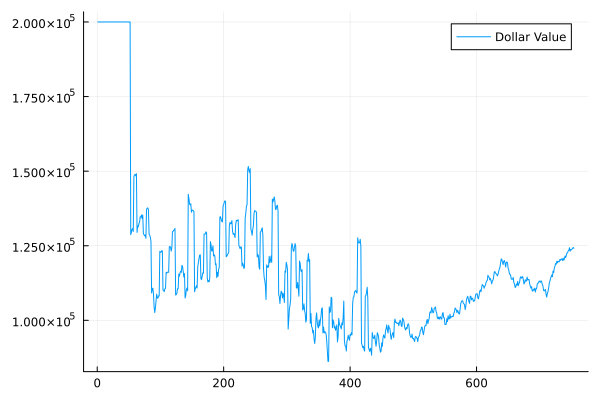

In [15]:
using Plots

in_data = stocks

evaluationEvents =[
    TimeEvent(t, "data_transfer") for t in sort(unique(in_data.date); rev=true)
]



my_init!(context) = algo_initialize!(context; lookahead=4, lpm_order=4.0, max_lookback=50, linear_lookback=2, tickers=tickers, transactionCost=0.0, initialCapital=10^5)
my_logic!(context, data) = algo_trading_logic!(context, data)
feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)
my_context = run(
    in_data,
    my_init!,
    my_logic!,
    my_execute_orders!,
    expose_data;
    audit=true,
    verbose=true,
    initialEvents=evaluationEvents,
)

dollar_symbol = "FEX/USD"

usdData = deepcopy(in_data[in_data.symbol .== my_context.extra.tickers[1], :])
usdData[!, "assetID"] .= dollar_symbol
usdData[!, "exchangeName"] .= "FEX"
usdData[!, "symbol"] .= "USD"
usdData[!, [:close, :high, :low, :open]] .= 1.0
usdData[!, [:volume]] .= 0
OHLCV_data = vcat(in_data, usdData)

# println(my_context.audit.portfolioHistory)

results = summarizePerformance(OHLCV_data, my_context; includeAccounts=true)
plot(results.dollarValue, label="Dollar Value")